# Introduction

We have discussed previously Language Modeling, which involves estimating the probabilities of sentences. Language Modeling plays a crucial role in natural language processing and has numerous practical applications in fields such as machine translation, spelling correction, and text generation. Previously, you have implemented language modeling using statistical methods and a Feed Forward Neural Network, but in this assignment, you will implement a language model using Long Short-Term Memory (LSTM) networks with peephole connections using the IMDB dataset.

The IMDB dataset, a popular benchmark dataset in sentiment analysis, consists of a collection of movie reviews labeled with their corresponding sentiment (positive or negative). Each review is preprocessed and represented as a sequence of words, with the task being to predict the sentiment polarity based on this textual input.

LSTM networks, especially those enhanced with peephole connections, offer advanced capabilities for remembering information over long periods, which is essential for processing sequences such as text. Peephole connections allow the gates within the LSTM to access the constant error carousel (CEC), essentially the cell state, directly, enhancing the network's ability to manage its memory more effectively.

We're gearing up to implement an LSTM model that processes text using word embeddings. Our choice for this task is the GloVe word embedding, a topic we've already explored in detail previously.

By the end of this assignment, you will have gained valuable insights into Neural Language Modeling using LSTM networks and acquired practical skills in designing, training, and evaluating language models.


In [ ]:
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras import preprocessing, models
from tensorflow import keras
from tqdm import tqdm
import tensorflow.keras.utils as ku
import math
import tensorflow.keras.backend as K


# Data pre-processing


Let's first setup the environment for training our neural network for sentiment classification using the IMDB dataset. We will:

- **Define Parameters:**
    - `vocab_size`: Specifies the number of words to consider as features.
    - `embedding_dim`: Sets the dimensionality of word embeddings.
    - `maxlen`: Determines the maximum length of a sentence to be fed into the FFNN.
- **Load the IMDB Dataset:**
    - Uses the keras.datasets.imdb.load_data function to load the IMDB dataset, which consists of movie reviews labeled with their corresponding sentiment (positive or negative).
    - Sets parameters such as `num_words`, `start_char`, `oov_char`, and `index_from` for loading the data.
- **Retrie Word Index Mapping:**
    - Retrieves the word index file mapping words to indices using `keras.datasets.imdb.get_word_index()`.
- **Create Reverse Word Index Mapping:**
    - Reverses the word index to obtain a dictionary mapping indices to words (id_to_word).
    - Adds special characters `[PAD`], `[START]`, and `[OOV]` to id_to_word to handle padding, start of sequence, and out-of-vocabulary words.
- **Updating Vocabulary Size:**
    - Updates vocab_size to account for the special characters added (`[PAD]`, `[START]`, and `[OOV]`).


These data preprocessing steps are required before training the FFNN for sentiment classification on the IMDB dataset.

In [ ]:
# Number of words to consider as features
vocab_size = 10000
# Dimensionality of word embeddings
embedding_dim = 50
# Maximum length of a sentence we will feed to our FFNN
maxlen = 250

# Load the data as lists of integers.

# Use the default parameters to keras.datasets.imdb.load_data
pad_char = 0  # Character used for padding sequences
start_char = 1  # Character used to indicate the start of a sequence
oov_char = 2  # Character used to indicate out-of-vocabulary words
index_from = 2  # Index offset for word indices

# Retrieve the training sequences.
(x_train, y_train), (x_test, y_test) = keras.datasets.imdb.load_data(
    num_words=vocab_size, start_char=start_char, oov_char=oov_char, index_from=index_from
)

# Retrieve the word index file mapping words to indices
word_index = keras.datasets.imdb.get_word_index()

# Reverse the word index to obtain a dict mapping indices to words
# And add `index_from` to indices to sync with `x_train`
id_to_word = dict(
    (i + index_from, word) for (word, i) in word_index.items()
)

# Update `id_to_word` to include special characters: `[PAD]`, `[START]`, and `[OOV]`
id_to_word[pad_char] = "[PAD]"
id_to_word[start_char] = "[START]"
id_to_word[oov_char] = "[OOV]"

# Create a word index mapping indices to words
word_index = dict(
    (i, word) for (word, i) in id_to_word.items()
)

# Update `vocab_size` to account for special characters: `[PAD]`, `[START]`, and `[OOV]`
vocab_size = vocab_size + 3


## <span style="color:red"><b>Task 1</b></span>

Now, you need to generate input sequences for training your model using n-gram sequences extracted from the training data. You should iterates through each instance in the training data, constructs n-gram sequences up to a specified length (15), pads sequences to ensure uniform length, and separates input features from labels.

In [ ]:
# Set the size of input sequences
input_seq_size = 15

# Load the word index from the dataset
word_index = imdb.get_word_index()
word_index = {k: (v + 3) for k, v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2
word_index["<UNUSED>"] = 3
id_to_word = {value: key for key, value in word_index.items()}

# Load training data
(x_train, _), (_, _) = imdb.load_data(num_words=vocab_size, start_char=start_char, oov_char=oov_char, index_from=index_from)

# Prepare n-gram sequences
input_sequences = []
for line in x_train:
    for i in range(2, min(len(line), input_seq_size) + 1):
        n_gram_sequence = line[:i]
        input_sequences.append(n_gram_sequence)

# Pad sequences
input_sequences = preprocessing.sequence.pad_sequences(input_sequences, maxlen=input_seq_size, padding='pre')

# Split input and label
input_to_model, label = input_sequences[:, :-1], np.reshape(input_sequences[:, -1], (-1, 1))


Let's display ene padded training sequence as a comprehensible piece of text, accompanied by its taget **word** label to gain insight into the preprocessed data. This visualization aids in understanding the data structure and ensures the correctness of preprocessing steps before model training.

In [ ]:
sample = 67793

print(F'The entry "{sample}" in "input_sequences" is: ')
print(input_sequences[sample])
print("It corresponds to the following input to our model:")
input_sentence = ' '.join([id_to_word[id_] for id_ in input_to_model[sample]])
print(f'{input_to_model[sample]} ({input_sentence})')
print(f' and the following target: {label[sample]} ({id_to_word[label[sample][0]]})')


The entry "67793" in "input_sequences" is: 
[   0    0    0    0    0    0    0    0    1 1044    5 2899  113    8
   37]
It corresponds to the following input to our model:
[   0    0    0    0    0    0    0    0    1 1044    5 2899  113    8] (<PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <START> plain and wears life to)
 and the following target: [37] (who)


We will now download and extract the GloVe word embedding file and we will use `glove.6B.50d.txt` in which each word is represented using a 50 dimentional space.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
data_path='/content/drive/MyDrive/glove_embeddings/glove.6B.50d.txt'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Initialize an empty dictionary to store word embeddings
embeddings_index = {}

# Open the GloVe word embedding file for reading
f = open(data_path)

# Iterate through each line in the file
for line in f:
    # Split each line into a list of values (space-separated)
    values = line.split()
    # Extract the word (the first value in the list)
    word = values[0]
    # Convert the remaining values to a NumPy array of float32 type,
    # representing the word vector (embedding)
    coefs = np.asarray(values[1:], dtype='float32')
    # Add the word and its corresponding embedding to the dictionary
    embeddings_index[word] = coefs

# Close the file after processing
f.close()

# Print the total number of word vectors (embeddings) loaded
print('Found %s word vectors.' % len(embeddings_index))

Found 400001 word vectors.


We now iterate through each word in the vocabulary, retrieves its pre-trained GloVe embedding vector (if available), and assigns it to the corresponding row in the embedding matrix. If no pre-trained embedding is found for a word, the corresponding row in the embedding matrix remains all-zeros.


In [ ]:
# Initialize an empty matrix to store the embedding vectors for each word in the vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

# Iterate through each word index in the vocabulary
for id_ in range(vocab_size):
    # Retrieve the word corresponding to the current index
    word = id_to_word[id_]
    # Attempt to retrieve the embedding vector for the word from the pre-trained GloVe embeddings
    embedding_vector = embeddings_index.get(word)
    # Check if an embedding vector is found for the word
    if embedding_vector is not None:
        # If an embedding vector is found, assign it to the corresponding row in the embedding matrix
        embedding_matrix[id_] = embedding_vector
    # If no embedding vector is found (i.e., the word is not present in the pre-trained embeddings),
    # the corresponding row in the embedding matrix remains all-zeros, indicating that the word has no pre-trained embedding


# Build your Peephole LSTM Layer


## <span style="color:red"><b>Task 2</b></span>

We will be incorporating an LSTM layer with peephole connections, which enable the gates to access the constant error carousel (CEC), represented by the cell state. This allows for enhanced control over the information flow within the network. ${\displaystyle h_{t-1}}$ is not used, ${\displaystyle c_{t-1}}$ is used instead in most places.
The operations within our Peephole LSTM Layer during a forward pass can be expressed as:



$${\displaystyle {\begin{aligned}f_{t}&=\sigma _{g}(W_{f}x_{t}+U_{f}c_{t-1}+b_{f})\\i_{t}&=\sigma _{g}(W_{i}x_{t}+U_{i}c_{t-1}+b_{i})\\o_{t}&=\sigma _{g}(W_{o}x_{t}+U_{o}c_{t-1}+b_{o})\\c_{t}&=f_{t}\odot c_{t-1}+i_{t}\odot \sigma _{c}(W_{c}x_{t}+b_{c})\\h_{t}&=o_{t}\odot \sigma _{h}(c_{t})\end{aligned}}}$$

where:

- ${\displaystyle x_{t}\in \mathbb {R} ^{d}}$: input vector to the LSTM unit
- ${\displaystyle f_{t}\in {(0,1)}^{h}}$: forget gate's activation vector
- ${\displaystyle i_{t}\in {(0,1)}^{h}}$: input/update gate's activation vector
- ${\displaystyle o_{t}\in {(0,1)}^{h}}$: output gate's activation vector
- ${\displaystyle h_{t}\in {(-1,1)}^{h}}$: hidden state vector also known as output vector of the LSTM unit
- ${\displaystyle c_{t}\in \mathbb {R} ^{h}}$: cell state vector
- ${\displaystyle W\in \mathbb {R} ^{h\times d}}$, ${\displaystyle U\in \mathbb {R} ^{h\times h}}$ and ${\displaystyle b\in \mathbb {R} ^{h}}$: weight matrices and bias vector parameters which need to be learned during training


In [ ]:
class PeepholeLSTM(keras.layers.Layer):
    def __init__(self, units, return_sequences=False, return_state=False, **kwargs):
        super(PeepholeLSTM, self).__init__(**kwargs)
        self.units = units
        self.return_sequences = return_sequences
        self.return_state = return_state

    def build(self, input_shape):
        input_dim = input_shape[-1]

        # Input gate
        self.Wi = self.add_weight(shape=(input_dim, self.units), initializer='glorot_uniform', name='Wi')
        self.Ui = self.add_weight(shape=(self.units, self.units), initializer='orthogonal', name='Ui')
        self.Ci = self.add_weight(shape=(self.units,), initializer='zeros', name='Ci')
        self.bi = self.add_weight(shape=(self.units,), initializer='zeros', name='bi')

        # Forget gate
        self.Wf = self.add_weight(shape=(input_dim, self.units), initializer='glorot_uniform', name='Wf')
        self.Uf = self.add_weight(shape=(self.units, self.units), initializer='orthogonal', name='Uf')
        self.Cf = self.add_weight(shape=(self.units,), initializer='zeros', name='Cf')
        self.bf = self.add_weight(shape=(self.units,), initializer='zeros', name='bf')

        # Output gate
        self.Wo = self.add_weight(shape=(input_dim, self.units), initializer='glorot_uniform', name='Wo')
        self.Uo = self.add_weight(shape=(self.units, self.units), initializer='orthogonal', name='Uo')
        self.Co = self.add_weight(shape=(self.units,), initializer='zeros', name='Co')
        self.bo = self.add_weight(shape=(self.units,), initializer='zeros', name='bo')

        # Cell candidate
        self.Wc = self.add_weight(shape=(input_dim, self.units), initializer='glorot_uniform', name='Wc')
        self.Uc = self.add_weight(shape=(self.units, self.units), initializer='orthogonal', name='Uc')
        self.bc = self.add_weight(shape=(self.units,), initializer='zeros', name='bc')

    def call(self, inputs, initial_state=None):
        batch_size = tf.shape(inputs)[0]
        timesteps = tf.shape(inputs)[1]

        h = tf.zeros((batch_size, self.units)) if initial_state is None else initial_state[0]
        c = tf.zeros((batch_size, self.units)) if initial_state is None else initial_state[1]
        outputs = []

        for t in range(inputs.shape[1]):
            x_t = inputs[:, t, :]

            i = tf.sigmoid(tf.matmul(x_t, self.Wi) + tf.matmul(h, self.Ui) + self.Ci * c + self.bi)
            f = tf.sigmoid(tf.matmul(x_t, self.Wf) + tf.matmul(h, self.Uf) + self.Cf * c + self.bf)
            o = tf.sigmoid(tf.matmul(x_t, self.Wo) + tf.matmul(h, self.Uo) + self.Co * c + self.bo)
            c_hat = tf.tanh(tf.matmul(x_t, self.Wc) + tf.matmul(h, self.Uc) + self.bc)

            c = f * c + i * c_hat
            h = o * tf.tanh(c)

            outputs.append(h)

        outputs = tf.stack(outputs, axis=1)

        if self.return_state:
            final_output = outputs if self.return_sequences else outputs[:, -1]
            return final_output, h, c

        return outputs if self.return_sequences else outputs[:, -1]


Test your code:

In [ ]:
inputs = np.random.random((32, 10, 8))
lstm = PeepholeLSTM(4, return_sequences=True, return_state=True)
whole_seq_output, final_memory_state, final_carry_state = lstm(inputs)
assert whole_seq_output.shape == (32, 10, 4), 'Test failed!'
print('Test successful')
assert final_memory_state.shape == (32, 4), 'Test failed!'
print('Test successful')
assert final_carry_state.shape == (32, 4), 'Test failed!'
print('Test successful')



Test successful
Test successful
Test successful


# Define the network

Let's construct the neural network based on the following architecture (roughly).

![Image Title](architecture.png)

## <span style="color:red"><b>Task 3</b></span>
Implement this architecture:


In [ ]:
model = keras.Sequential([
    keras.layers.Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], trainable=False, input_length=input_seq_size),
    PeepholeLSTM(128, return_sequences=True),
    keras.layers.BatchNormalization(),
    PeepholeLSTM(128, return_sequences=False),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(256, activation='relu'), # Assuming a ReLU activation for the Dense layer
    keras.layers.Dense(vocab_size, activation='softmax')
])

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print a summary of the model
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │       500,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ peephole_lstm_1 (PeepholeLSTM)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ peephole_lstm_2 (PeepholeLSTM)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 500,150 (1.91 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 500,150 (1.91 MB)

Execute the following cell to initiate the training process. It may take some time to complete, but the execution time will be significantly reduced if you utilize a **GPU** or **TPU**.


In [ ]:
# One-hot encode the labels
label = ku.to_categorical(label, num_classes=vocab_size)

history = model.fit(input_to_model,
                    label,
                    epochs=20,
                    batch_size=1024)

Epoch 1/20
342/342 ━━━━━━━━━━━━━━━━━━━━ 55s 80ms/step - accuracy: 0.0774 - loss: 6.5258
Epoch 2/20
342/342 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.1452 - loss: 5.3567
Epoch 3/20
342/342 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.1679 - loss: 4.9927
Epoch 4/20
342/342 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.1827 - loss: 4.7251
Epoch 5/20
342/342 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.1953 - loss: 4.4834
Epoch 6/20
342/342 ━━━━━━━━━━━━━━━━━━━━ 14s 40ms/step - accuracy: 0.2036 - loss: 4.3031
Epoch 7/20
342/342 ━━━━━━━━━━━━━━━━━━━━ 14s 40ms/step - accuracy: 0.2182 - loss: 4.1194
Epoch 8/20
342/342 ━━━━━━━━━━━━━━━━━━━━ 14s 40ms/step - accuracy: 0.2310 - loss: 3.9672
Epoch 9/20
342/342 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.2429 - loss: 3.8503
Epoch 10/20
342/342 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.2567 - loss: 3.7289
Epoch 11/20
342/342 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.2656 - loss: 3.6381
Epoch 12/20
342/342 ━━━━━━━━━━

Let's plot the learning curves for our network:


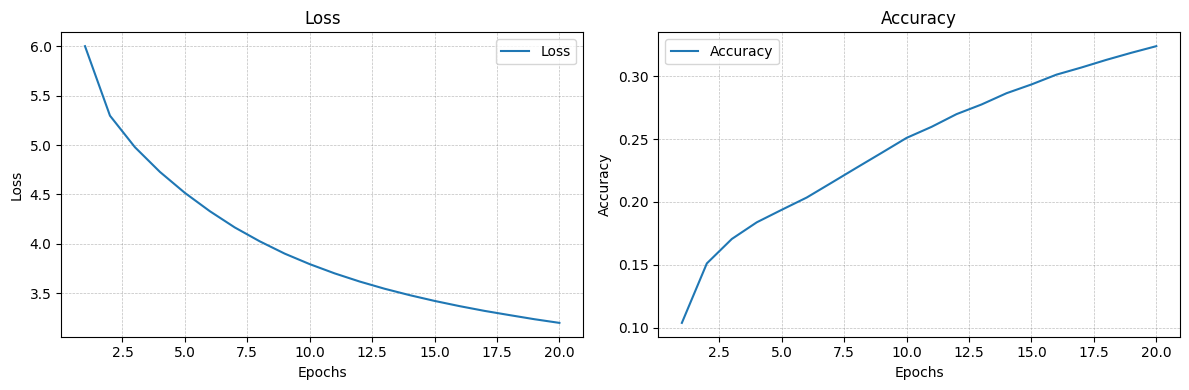

In [ ]:
plt.figure(figsize=(12, 4))

ax1 = plt.subplot(1, 2, 1)
x = range(1, len(history.history['loss']) + 1)
plt.plot(x, history.history['loss'], label='Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.5)
plt.legend()

ax2 = plt.subplot(1, 2, 2)
plt.plot(x, history.history['accuracy'], label='Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.5)
plt.legend()

plt.tight_layout()
plt.show()


# Text generation

## <span style="color:red"><b>Task 4</b></span>

Utilize the language model to generate text by following these steps: Begin with a seed sentence, which you feed into the network. Select the word with the highest probability, append it to your initial sentence, and feed it back into your network to generate the following word. Repeat this process 10-20 times to generate a complete sentence.



In [ ]:
def generate(seed_text):
    # Tokenize the seed text
    seed_sequence = [word_index.get(word, oov_char) for word in seed_text.split()]

    # Pad the seed sequence to the input length of the model
    # The input length is input_seq_size (16), but the model takes input_seq_size - 1 (15) words for prediction
    # So, pad to input_seq_size - 1 and then take the last input_seq_size - 1 elements if the sequence is longer
    padded_sequence = preprocessing.sequence.pad_sequences([seed_sequence], maxlen=input_seq_size - 1, padding='pre')

    # Number of words to generate
    num_words_to_generate = 15 # You can adjust this number

    generated_text = seed_text

    for _ in range(num_words_to_generate):
        # Get the model's prediction for the next word
        predicted_probabilities = model.predict(padded_sequence, verbose=0)[0]

        # Get the index of the word with the highest probability
        predicted_word_index = np.argmax(predicted_probabilities)

        # Convert the index back to a word
        predicted_word = id_to_word[predicted_word_index]

        # Append the predicted word to the generated text
        generated_text += " " + predicted_word

        # Update the padded sequence to include the newly generated word
        # Remove the first element and append the new word ID
        new_sequence = np.append(padded_sequence[0][1:], predicted_word_index)
        padded_sequence = np.array([new_sequence])

    return generated_text



Use your Languange Model with the following seed text:

In [ ]:
seed_text = 'the movie is terrible but'
generate(seed_text)

"the movie is terrible but far i with that <UNUSED> other no it isn't in of <UNUSED> <UNK> message of"

# Congratulations!


Congratulations on completing the assignment! Your dedication and effort are commendable. By successfully working through the coding exercises and written exercises, you have demonstrated a strong understanding of LSTM-based Neural Nets.






# Acknowledgement

## About the Author

This notebook was authored by Mohamed Reda Bouadjenek. He is a Senior Lecturer (Assistant Professor) of Applied Artificial Intelligence in the School of Information Technology at Deakin University, Australia.



## Disclaimer

Even though your code passes all unit test cases, it does not guarantee absolute correctness. The complexity of real-world scenarios can sometimes lead to unforeseen edge cases that may not have been covered by the test suite. As a result, it's essential to exercise caution and conduct thorough testing to ensure the robustness and reliability of the code in all possible cases.

## Version History
- Version 1.0 (Initial Release): Released on 06/05/2024.

## Contact Information

- **Email:** reda.bouadjenek@deakin.edu.au
- **GitHub:** https://github.com/rbouadjenek/

---
